### 코더의 소회 : 
날씨 : 오늘의 학습 < 흐림☁️ >했습니다. [☀️⛅☁️🌧️🌩️⛈️]
- 배운점 : 모델별로 데이터 전처리 꼭 필요하다는 것. 딥러닝(텍스트 입력) 머신러닝(배열차원 낮춰서 정수시퀀스 입력) 입력 다르게해야함
- 아쉬운점 :  시간조절 실패. 속상함.
- 느낀점 : 언제 어떤 오류가 날지 모른다. 항상 일찍 끝내는 것을 목표로하자

(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr02)

### 전체 코드 실행 플로우 (목차):

**STEP 0. 라이브러리 및 데이터 불러오기**    
**STEP 1. EDA(탐색적 데이터 분석)**  
**STEP 2. 데이터 전처리 및 준비**  
**STEP 3. 머신러닝 모델1~4**  
	- 각 모델별 모델학습, 테스트 정밀도, 재현율, F1점수 계산  
**STEP 4. 머신러닝 모델간 성능비교 및 시각화**  
**STEP 5. 딥러닝 모델**  
	- 토큰화 및 시퀀스변환, 토크나이저 설정 및 학습, 시퀀스 변환 및 패딩,  
    - 딥러닝 모델 정의, 모델 학습, 테스트 데이터 성능 평가  
**STEP 6. 머신러닝 모델 VS. 딥러닝 모델**  


---

# STEP 0. 라이브러리 및 데이터 불러오기

In [1]:
# !pip install tqdm

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import seaborn as sns
from tqdm import tqdm

In [3]:
# 로이터 데이터셋 로드 (5000개 단어 사용)
words = 5000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=words, test_split=0.2)

In [4]:
# 로이터 데이터셋 로드 (모든 단어 사용)
words = None
(x_train_all, y_train_all), (x_test_all, y_test_all) = reuters.load_data(num_words=words, test_split=0.2)

---

# STEP 1. EDA(탐색적 데이터 분석)
---

<호기심> "num_words 다르면 샘플 수 등에서 차이가 있을까?"

In [5]:
# 탐색적 데이터 분석 (EDA)
print(f"훈련 샘플 수: {len(x_train)}")
print(f"테스트 샘플 수: {len(x_test)}")
print(f"클래스 수: {np.max(y_train) + 1}")

훈련 샘플 수: 8982
테스트 샘플 수: 2246
클래스 수: 46


In [6]:
print(f"훈련 샘플 수: {len(x_train_all)}")
print(f"테스트 샘플 수: {len(x_test_all)}")
print(f"클래스 수: {np.max(y_train_all) + 1}")

훈련 샘플 수: 8982
테스트 샘플 수: 2246
클래스 수: 46


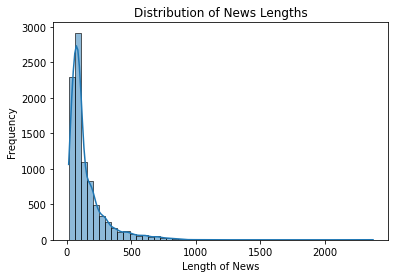

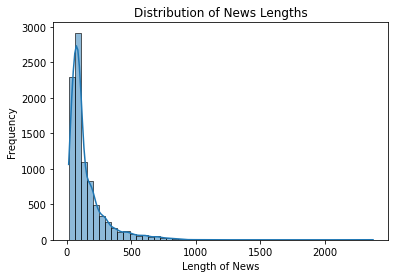

In [7]:
# 뉴스 길이 분포 시각화
news_lengths = [len(x) for x in x_train]
sns.histplot(news_lengths, bins=50, kde=True)
plt.title('Distribution of News Lengths')
plt.xlabel('Length of News')
plt.ylabel('Frequency')
plt.show()
news_lengths_all = [len(x) for x in x_train_all]
sns.histplot(news_lengths_all, bins=50, kde=True)
plt.title('Distribution of News Lengths')
plt.xlabel('Length of News')
plt.ylabel('Frequency')
plt.show()

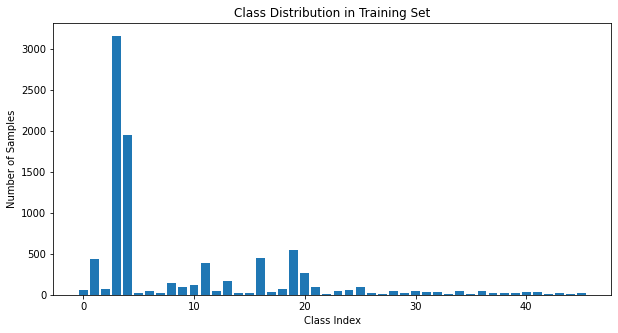

In [8]:
# 클래스 분포 시각화
class_counts = np.bincount(y_train)
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.show()

👁️👁️Data Review : 

---

# STEP 2. 데이터 전처리 및 준비
---

In [9]:
# 중첩된 리스트 및 일관되지 않은 데이터 유형 확인
def check_data(data):
    # 데이터에서 중첩된 리스트 및 일관되지 않은 데이터 유형을 확인함.
    for i, row in enumerate(data):
        if not isinstance(row, (list, np.ndarray)):
            print(f"행 {i}는 리스트 또는 배열이 아닙니다: {row}")
        else:
            for j, element in enumerate(row):
                if not isinstance(element, (int, float)):
                    print(f"행 {i}의 요소 {j}는 숫자가 아닙니다: {element}")

# x_train 데이터에 검사 적용
print(check_data(x_train))
print(check_data(x_train_all))

None
None


In [10]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# x_train과 x_test가 리스트의 리스트라고 가정합니다.
mlb = MultiLabelBinarizer()
x_train = mlb.fit_transform(x_train)
x_test = mlb.transform(x_test)
x_train_all = mlb.fit_transform(x_train_all)
x_test_all = mlb.transform(x_test_all)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:870: UserWarning: unknown class(es) [10015, 10069, 10141, 10211, 10241, 10290, 10409, 10453, 10477, 10491, 10632, 10733, 10824, 11096, 11112, 11114, 11160, 11203, 11243, 11278, 11292, 11302, 11314, 11331, 11340, 11346, 11348, 11360, 11395, 11481, 11559, 11686, 11778, 11835, 11888, 11921, 11995, 12035, 12057, 12138, 12165, 12183, 12211, 12223, 12230, 12235, 12241, 12285, 12292, 12296, 12351, 12357, 12383, 12414, 12468, 12479, 12487, 12494, 12547, 12557, 12709, 12714, 12760, 12776, 12784, 12824, 12837, 12840, 12928, 12935, 12985, 12991, 12994, 13010, 13011, 13037, 13076, 13087, 13113, 13122, 13145, 13149, 13216, 13248, 13260, 13263, 13283, 13286, 13363, 13457, 13488, 13494, 13496, 13556, 13572, 13581, 13594, 13642, 13643, 13654, 13673, 13674, 13685, 13744, 13748, 13770, 13776, 13784, 13800, 13822, 13827, 13857, 13865, 13868, 13878, 13960, 13971, 13976, 13979, 14003, 14014, 14019, 14035, 14045, 14090, 14101, 14103, 141

👁️👁️Data Comment :   
  처음에 "로이터 데이터는 정수 시퀀스로 변환되어 있기에 전처리 준비가 필요 없다."라고 생각했는데,   
   - "ValueError: setting an array element with a sequence"  
   - "TypeError: float() argument must be a string or a real number, not 'list'" 
     
     
       - 위 두 에러가 발생했다. 
       - 위 에러들은 x_train 또는 x_test **데이터에 문제**가 있음을 나타내는 것  
       - 변수에 단일 숫자 값 대신 리스트 또는 시퀀스를 포함하고 있을 가능성이 높으며, 이로 인해 모델 학습 (model.fit) 과정에서 문제가 발생함  
  

---

# STEP 3. 머신러닝 모델1~4
**(각 모델별 모델학습, 테스트 정밀도, 재현율, F1점수 계산)**  
머신러닝 모델 : 나이브 베이즈, CNB, 로지스틱 회귀, SVM

--- 


#### 머신러닝 모델 설정 : 나이브 베이즈, CNB, 로지스틱 회귀, SVM
 

In [11]:
model_1 = MultinomialNB()
model_2 = ComplementNB(alpha=0.5)
# model_3 = LogisticRegression(max_iter=1000)
# model_4 = SVC(kernel='linear')

#### 머신러닝 모델 평가 함수 

In [12]:
def evaluate_ml_model(name, model):
    print(f"\nTraining {name}...")
    with tqdm(total=len(x_train)) as pbar:
        model.fit(x_train, y_train)
        pbar.update(len(x_train))
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    ml_results.append((name, accuracy, precision, recall, f1))
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_test, y_pred))

In [13]:
def evaluate_ml_model_all(name, model):
    print(f"\nTraining {name}...")
    with tqdm(total=len(x_train_all)) as pbar:
        model.fit(x_train_all, y_train_all)
        pbar.update(len(x_train_all))
    y_pred = model.predict(x_test_all)
    accuracy = accuracy_score(y_test_all, y_pred)
    precision = precision_score(y_test_all, y_pred, average='weighted')
    recall = recall_score(y_test_all, y_pred, average='weighted')
    f1 = f1_score(y_test_all, y_pred, average='weighted')
    ml_results.append((name, accuracy, precision, recall, f1))
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_test_all, y_pred))

#### 머신러닝 모델 평가

In [34]:
ml_results = []
dl_results = []

In [35]:
print(ml_results)

[]


In [36]:
evaluate_ml_model('NB', model_1)



Training NB...


100%|██████████| 8982/8982 [00:39<00:00, 226.71it/s]


Model: NB
Accuracy: 0.7564559216384684
Precision: 0.7460009003066336
Recall: 0.7564559216384684
F1 Score: 0.7387338733652257
              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.54      0.83      0.65       105
           2       0.83      0.50      0.62        20
           3       0.94      0.87      0.91       813
           4       0.77      0.91      0.83       474
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67        14
           7       1.00      0.33      0.50         3
           8       0.60      0.74      0.66        38
           9       0.67      0.72      0.69        25
          10       0.69      0.67      0.68        30
          11       0.57      0.71      0.63        83
          12       0.67      0.31      0.42        13
          13       0.50      0.78      0.61        37
          14       0.00      0.00      0.00         2
         


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308:

In [ ]:
evaluate_ml_model_all('NB_all', model_1)


Training NB_all...


  0%|          | 0/8982 [00:00<?, ?it/s]

In [ ]:
evaluate_ml_model('CNB', model_2)

In [ ]:
evaluate_ml_model_all('CNB_all', model_2)

👁️👁️Data Review : 

  **테스트 정밀도 / 재현율 / F1점수**  
  
    - (1) 나이브 베이즈(Naive Bayes, NB) :  /  /   
    - (2) CNB :  /  /   
    - (3) 로지스틱 회귀 :  /  /   
    - (4) 서포트 벡터 머신(SVM) :  /  /  

---

# STEP 4. 머신러닝 모델간 성능비교 및 시각화
---

#### 머신러닝 모델 4가지 평가 바차트로 비교해보기

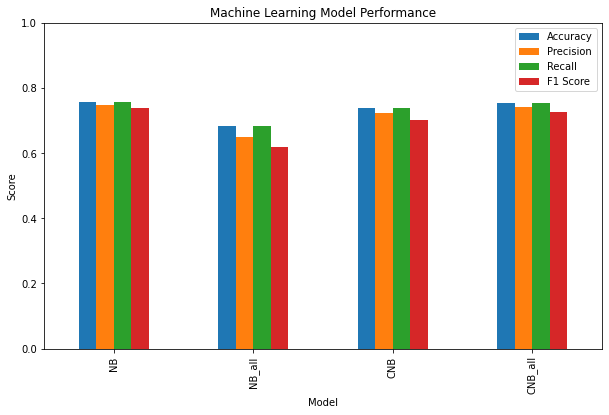

In [19]:
# 머신러닝 모델 성능 시각화
ml_results_df = pd.DataFrame(ml_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
ml_results_df.set_index('Model', inplace=True)
ml_results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Machine Learning Model Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

👁️👁️Data Review : 

---

# STEP 5. 딥러닝 모델
**(토큰화 및 시퀀스변환, 토크나이저 설정 및 학습, 시퀀스 변환 및 패딩, 딥러닝 모델 정의, 모델 학습, 테스트 데이터 성능 평가)**

---

In [22]:
# 딥러닝 모델: 하이브리드 CNN + RNN(using all words)
num_classes_all = np.max(y_train_all) + 1

# Tokenize and Pad Sequences 
# 시퀀스 토크나이징 및 패딩(using all words)
# Preprocess data: Convert sequences to texts (for tokenizer)
word_index = reuters.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2] = "<PAD>", "<START>", "<UNK>"

def decode_news(sequence):
    return ' '.join([index_word.get(i, '?') for i in sequence])

x_train_all_text = [decode_news(x) for x in x_train_all]
x_test_all_text = [decode_news(x) for x in x_test_all]


# Tokenize and Pad Sequences (using all words)
tokenizer_all = Tokenizer(num_words=None)
tokenizer_all.fit_on_texts(x_train_all_text)
x_train_all_seq = tokenizer_all.texts_to_sequences(x_train_all_text)
x_test_all_seq = tokenizer_all.texts_to_sequences(x_test_all_text)


565248/550378 [==============================] - 0s 0us/step


In [26]:
x_train_all_padded = pad_sequences(x_train_all_seq, maxlen=300)
x_test_all_padded = pad_sequences(x_test_all_seq, maxlen=300)

y_train_all_cat = to_categorical(y_train_all, num_classes_all)
y_test_all_cat = to_categorical(y_test_all, num_classes_all)

In [31]:
model_all = Sequential([
    Embedding(input_dim=len(tokenizer_all.word_index) + 1, output_dim=128, input_length=300),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64),
    Dense(num_classes_all, activation='softmax')
])

model_all.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_all.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          384       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 32)           12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 149, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 40,526
Trainable params: 40,526
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
# Train Model (using all words) with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_all.fit(x_train_all_padded, y_train_all_cat, epochs=20, batch_size=64, validation_data=(x_test_all_padded, y_test_all_cat), callbacks=[early_stopping])

Epoch 1/20
141/141 [==============================] - 42s 13ms/step - loss: 2.5549 - accuracy: 0.3489 - val_loss: 2.4200 - val_accuracy: 0.3620
Epoch 2/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4111 - accuracy: 0.3517 - val_loss: 2.4228 - val_accuracy: 0.3620
Epoch 3/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4099 - accuracy: 0.3517 - val_loss: 2.4191 - val_accuracy: 0.3620
Epoch 4/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4115 - accuracy: 0.3517 - val_loss: 2.4166 - val_accuracy: 0.3620
Epoch 5/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4099 - accuracy: 0.3517 - val_loss: 2.4179 - val_accuracy: 0.3620
Epoch 6/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4090 - accuracy: 0.3517 - val_loss: 2.4222 - val_accuracy: 0.3620
Epoch 7/20
141/141 [==============================] - 1s 9ms/step - loss: 2.4089 - accuracy: 0.3517 - val_loss: 2.4225 - val_accuracy: 0.3620


In [33]:
# 모델 평가
loss_all, accuracy_all = model_all.evaluate(x_test_all_padded, y_test_all_cat)
print(f"\n테스트 정확도: {accuracy_all}")
dl_results.append(('Hybrid CNN+RNN (all words)', accuracy_all))

71/71 [==============================] - 0s 6ms/step - loss: 2.4166 - accuracy: 0.3620

테스트 정확도: 0.36197686195373535


NameError: name 'dl_results' is not defined

👁️👁️Data Review : 

In [ ]:

'''
# Deep Learning Model: Hybrid CNN + RNN (using top 5000 words)
num_classes_5000 = np.max(y_train_5000) + 1

# Tokenize and Pad Sequences (using top 5000 words)
x_train_5000_text = [decode_news(x) for x in x_train_5000]
x_test_5000_text = [decode_news(x) for x in x_test_5000]

# Tokenize and Pad Sequences (using top 5000 words)
tokenizer_5000 = Tokenizer(num_words=5000)
tokenizer_5000.fit_on_texts(x_train_5000_text)
x_train_5000_seq = tokenizer_5000.texts_to_sequences(x_train_5000_text)
x_test_5000_seq = tokenizer_5000.texts_to_sequences(x_test_5000_text)

x_train_5000_padded = pad_sequences(x_train_5000_seq, maxlen=100)
x_test_5000_padded = pad_sequences(x_test_5000_seq, maxlen=100)

y_train_5000_cat = to_categorical(y_train_5000, num_classes_5000)
y_test_5000_cat = to_categorical(y_test_5000, num_classes_5000)
''''''

In [ ]:
'''
# Define Hybrid Model (using top 5000 words)
model_5000 = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(300, 5000)),
    MaxPooling1D(2),
    LSTM(64),
    Dense(num_classes_5000, activation='softmax')
])

model_5000.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_5000.summary()

# Train Model (using top 5000 words)
# Train Model (using top 5000 words) with Early Stopping
model_5000.fit(x_train_5000_padded, y_train_5000_cat, epochs=20, batch_size=64, validation_data=(x_test_5000_padded, y_test_5000_cat), callbacks=[early_stopping])
'''

In [ ]:
# Evaluate Model (using top 5000 words)
loss_5000, accuracy_5000 = model_5000.evaluate(x_test_5000_padded, y_test_5000_cat)
print(f"
Test Accuracy (5000 words): {accuracy_5000}")
dl_results.append(('Hybrid CNN+RNN (5000 words)', accuracy_5000))

---

# STEP 6. 머신러닝 모델 VS. 딥러닝 모델
---

In [ ]:
# Combine and visualize all results
dl_results_df = pd.DataFrame(dl_results, columns=['Model', 'Accuracy'])
dl_results_df.set_index('Model', inplace=True)
all_results_df = pd.concat([ml_results_df[['Accuracy']], dl_results_df])
all_results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance (all words and 5000 words)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

👁️👁️Data Review : 